# TP Final Analisis de Datos Espaciales

## Clasificador campo / no campo

Al trabajar con datos del agro, es frecuente encontrarse con NAs en las variables `lat, lon`. Para resolver este inconveniente, se suele entrar a Google Maps, escribir la localidad y buscar algun campo a mano para sacar esta información. El problema claro es que este procedimiento **no es escalable** para un alto volumen de NAs, por lo tanto queremos investigar que soluciones alternativas existen.

Después de participar de las clases de ADE se nos ocurrió entrenar un clasificador binario campo / no campo que, dado un raster de imágenes satelitales, identifique satisfactoriamente las potenciales ubicaciones de donde sacar coordenadas. Esto podría solucionar nuestro problema, ahorrando muchisimo tiempo al proceso de analizar datos agro.

## Encontramos un paper

 [*"Automating field boundary delineation with multi-temporal Sentinel-2 imagery"*](https://www.researchgate.net/publication/337182705_Automating_field_boundary_delineation_with_multi-temporal_Sentinel-2_imagery)

 Usan técnicas de aprendizaje no supervisado que nos gustaría investigar (Canny Edge Detection, Watershed Segmentation) y comparar con un clasficiador supervisado por pixel. Los autores del paper sostienen que el análisis de imagen orientado a objetos (OBIA) supera limitaciones de las clasificaciones por pixel al **eliminar la necesidad de datos de entrenamiento y mejorar la precision espacial** al delinear limites de campo cerrados.

### Objetivo general

Nuestro objetivo general es diseñar y evaluar un método automático para detectar y delimitar áreas de campo agrícola a partir de imagenes multitemporales de Sentinel-2.

Queremos utilizar un método del paper que clasifica campos, no por píxel, sino por un conjunto de ellos que selecciona mediante el metodo canny y watershed segmentation.

* Canny ayuda a distiguir Bordes, zonas donde el valor cambia bruscamente → como el límite entre dos parcelas.

* Watershed crea regiones cerradas, posibles campos agrícolas.

Objetivos específicos

1. Construir una representación multi-temporal por píxel (características espectrales y fenológicas) a partir de series Sentinel-2.

2. Implementar un pipeline no supervisado de delineación de campos basado en detección de bordes (Canny) + Watershed (según paper) y extraer segmentos candidatos.

3. a) En este punto no sabemos si usar un modelo supervisado donde usamos datos secundarios para crear etiquetas automáticas débiles. Por ejemplo Zonas urbanas de OpenStreetMap → etiquetamos como “no campo”, extraer polígonos de áreas rurales por la pag oficial del gobierno IGN y/o eliminación automática de cuerpos de agua, infraestructura, ciudades.
  
     b) La otra opcion podria ser un modelo no supervisado, clustering. Donde se analiza cada cluster y se asigna etiqueta por interpretación visual o por porcentaje de presencia rural.



4. Evaluar la precisión de detección y la utilidad práctica para imputar coordenadas.

### Un poquito más detallado.

### Canny
* Suaviza la imagen (ruido ↓)

* Calcula gradiente de intensidad

* Detecta máximos de gradiente (posibles bordes)

* Aplica umbrales para quedarse con bordes significativos

* Conecta bordes en líneas limpias


### Watershed

Imagina la imagen como un mapa de alturas:

* Los valores bajos = valles (cuencas)

* Los valores altos = cimas

Luego:

* “Llenan de agua” los valles

* Cuando dos cuencas se encuentran → aparece una línea divisoria

* Esas líneas son segmentaciones (regiones)

una vez obtenida las regiones se extraen los segmentos candidatos que queremos (campo), para eso filtrariamos según criterios geompetricos o espectrales. (Área mínima:	Campos no suelen ser muy pequeños, por su forma	los lotes suelen tener formas regulares, por su NDVI medio alto: Vegetación presente y por su variabilidad temporal: Cultivos cambian a lo largo del tiempo.

## Rasters INTA

Descargamos RASTERS de la campaña agricola 23/24, hay un raster para invierno y otro para verano.


In [12]:
import numpy as np
import glob
import os
import xml.etree.ElementTree as ET
from collections import defaultdict

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap, BoundaryNorm

import rasterio
import rasterio.enums
import pandas as pd

from skimage import feature, filters, segmentation, morphology
from scipy import ndimage as ndi

# ============================================================================
# CONFIGURACION DE PATHS - MODIFICAR AQUI PARA CAMBIAR RUTAS
# ============================================================================

# Directorios base
r_rasters = r"..\data\raw\sentinel_23_24"  # Directorio con rasters NDVI temporales
r_inta = r"..\data\raw\INTA_23_24"  # Directorio con rasters INTA
data_dir = os.path.join("..", "data", "raw", "sentinel_23_24")  # Mismo que r_rasters pero con os.path.join
data_proc_dir = os.path.join("..", "data", "proc")  # Directorio con datos procesados
out_dir = "img"  # Directorio de salida para imágenes

# Archivos INTA
tif_path_verano = os.path.join(r_inta, "MNC_verano-2024.tif")
tif_path_invierno = os.path.join(r_inta, "MNC_invierno2023.tif")
qml_path_ver = os.path.join("..", "data", "raw", "INTA_23_24", "MNC_ver24.qml")
qml_path_inv = os.path.join("..", "data", "raw", "INTA_23_24", "MNC_inv23.qml")

# Archivos procesados
raster_path = os.path.join("..", "data", "proc", "9_NDVI_con_recortes.tif")

# Crear directorio de salida si no existe
os.makedirs(out_dir, exist_ok=True)


In [13]:
# Mostrar solo características de los raster .tif en r_inta

inta_tif_files = glob.glob(os.path.join(r_inta, "*.tif"))

if len(inta_tif_files) == 0:
    print(f"No se encontraron archivos .tif en {r_inta}")
else:
    print(f"Se encontraron {len(inta_tif_files)} archivos .tif en {r_inta}\n")
    for idx, tif_path in enumerate(inta_tif_files, 1):
        with rasterio.open(tif_path) as src:
            print(f"Raster {idx}: {os.path.basename(tif_path)}")
            print(f"\tDimensiones (alto, ancho): {src.height} x {src.width}")
            print(f"\tN° bandas: {src.count}")
            print(f"\tTipo de dato: {src.dtypes[0]}")
            print(f"\tCRS: {src.crs}")
            print(f"\tPixel size (resolución): {src.res[0]} x {src.res[1]}")
            print(f"\tExtensión (bounds): {src.bounds}\n")


Se encontraron 2 archivos .tif en ..\data\raw\INTA_23_24

Raster 1: MNC_invierno2023.tif
	Dimensiones (alto, ancho): 70641 x 43994
	N° bandas: 1
	Tipo de dato: uint8
	CRS: EPSG:4326
	Pixel size (resolución): 0.0002694945852388963 x 0.0002694945852408658
	Extensión (bounds): BoundingBox(left=-67.476323746, bottom=-41.035940494, right=-55.620178963, top=-21.998573498)

Raster 2: MNC_verano-2024.tif
	Dimensiones (alto, ancho): 70641 x 43994
	N° bandas: 1
	Tipo de dato: uint8
	CRS: EPSG:4326
	Pixel size (resolución): 0.0002694945852388963 x 0.0002694945852408658
	Extensión (bounds): BoundingBox(left=-67.476323746, bottom=-41.035940494, right=-55.620178963, top=-21.998573498)



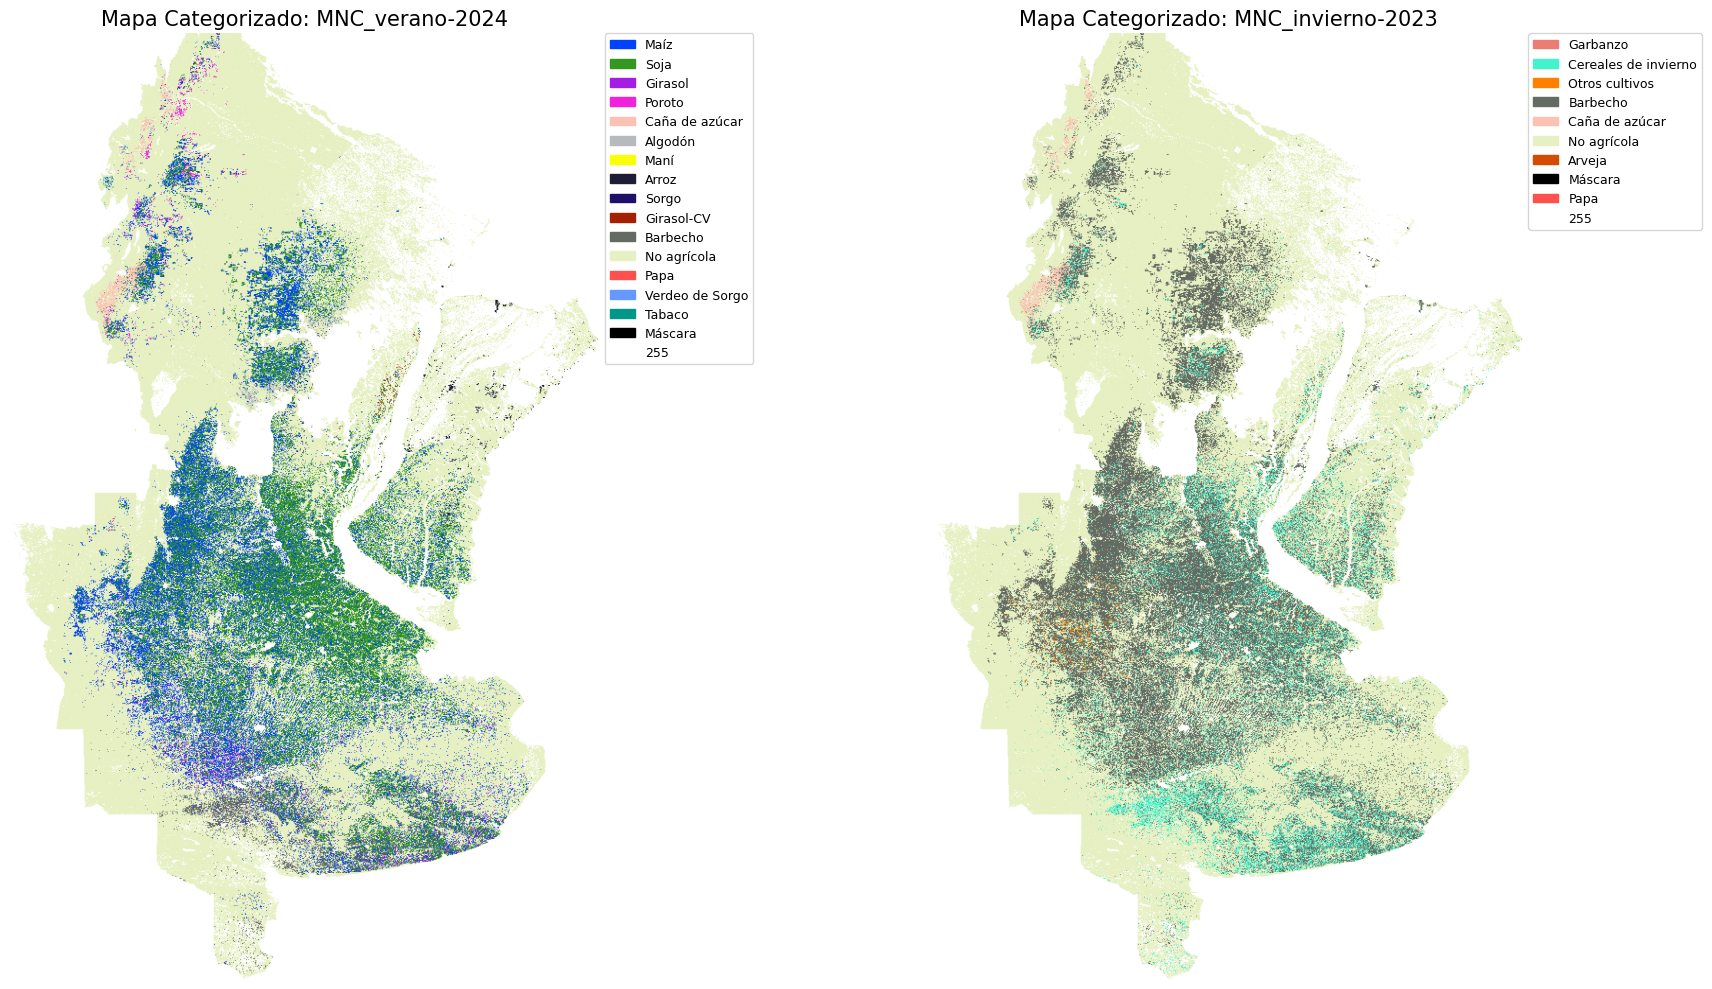

Imagen combinada guardada en: img\MNC_verano_invierno_combinado.png


In [14]:
# --- Visualización combinada: Verano e Invierno lado a lado ---

# Usar paths definidos en la celda 6
tif_path = tif_path_verano
tif_path_inv = tif_path_invierno

# --- Parse QML para VERANO ---
tree = ET.parse(qml_path_ver)
root = tree.getroot()

# Encontrar el nodo <colorrampshader>
shader = root.find(".//colorrampshader")
items = shader.findall(".//item")

# Extraer valores, etiquetas y colores - permitiendo tanto "R,G,B,A" como "#RRGGBB"
labels = []
vals = []
hex_colors = []
for it in items:
    vals.append(int(float(it.get("value"))))
    labels.append(it.get("label"))
    qml_col = it.get("color")
    if qml_col.startswith("#"):  # hexadecimal color
        hex_colors.append(qml_col.lower())
    else:
        # formateo "R,G,B,A"
        rgb_split = qml_col.split(",")
        if len(rgb_split) >= 3:
            try:
                rgb = tuple(map(int, rgb_split[:3]))
                hex_colors.append('#{:02x}{:02x}{:02x}'.format(*rgb))
            except Exception as e:
                hex_colors.append("#888888")
                print(f"[WARN] No se pudo interpretar color '{qml_col}': {e}")
        else:
            hex_colors.append("#888888")
            print(f"[WARN] Color desconocido para item con label '{it.get('label')}': '{qml_col}'")

# Ordenar por valor
z = sorted(zip(vals, hex_colors, labels), key=lambda t: t[0])
vals, hex_colors, labels = [list(x) for x in zip(*z)]

# Para BoundaryNorm, los boundaries deben ser valores exactos de corte de clase
boundaries = vals + [vals[-1] + 1]
cmap = ListedColormap(hex_colors)
norm = BoundaryNorm(boundaries, ncolors=len(hex_colors))

# --- Parse QML para INVIERNO ---
tree_inv = ET.parse(qml_path_inv)
root_inv = tree_inv.getroot()

labels_inv = []
vals_inv = []
hex_colors_inv = []

for it in root_inv.iter('item'):
    label = it.get('label')
    value = it.get('value')
    color = it.get('color')
    if label and value:
        labels_inv.append(label)
        vals_inv.append(int(float(value)))
        qml_col = color
        if qml_col is None:
            hex_colors_inv.append("#888888")
            continue
        if qml_col.startswith("#"):
            hex_colors_inv.append(qml_col)
        elif "," in qml_col:
            rgb_split = qml_col.split(",")
            try:
                rgb = tuple(map(int, rgb_split[:3]))
                hex_colors_inv.append('#{:02x}{:02x}{:02x}'.format(*rgb))
            except Exception as e:
                hex_colors_inv.append("#888888")
                print(f"[WARN] No se pudo interpretar color '{qml_col}': {e}")
        else:
            hex_colors_inv.append("#888888")
            print(f"[WARN] Color desconocido para item con label '{it.get('label')}': '{qml_col}'")

# Ordenar por valor
z_inv = sorted(zip(vals_inv, hex_colors_inv, labels_inv), key=lambda t: t[0])
vals_inv, hex_colors_inv, labels_inv = [list(x) for x in zip(*z_inv)]

# Para BoundaryNorm, los boundaries deben ser valores exactos de corte de clase
boundaries_inv = vals_inv + [vals_inv[-1] + 1]
cmap_inv = ListedColormap(hex_colors_inv)
norm_inv = BoundaryNorm(boundaries_inv, ncolors=len(hex_colors_inv))

# --- Leer los rasters y muestrear low-res ---
W_preview, H_preview = 1000, 1000

# Leer raster VERANO
with rasterio.open(tif_path) as src:
    img = src.read(
        1,
        out_shape=(H_preview, W_preview),
        resampling=rasterio.enums.Resampling.nearest
    )
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

# Leer raster INVIERNO
with rasterio.open(tif_path_inv) as src_inv:
    img_inv = src_inv.read(
        1,
        out_shape=(H_preview, W_preview),
        resampling=rasterio.enums.Resampling.nearest
    )
    extent_inv = [src_inv.bounds.left, src_inv.bounds.right, src_inv.bounds.bottom, src_inv.bounds.top]

# --- Visualización combinada ---
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Plot izquierdo: Verano
axes[0].imshow(img, cmap=cmap, norm=norm, extent=extent, origin='upper')
axes[0].set_title("Mapa Categorizado: MNC_verano-2024", fontsize=15)
axes[0].axis("off")
handles_ver = [mpatches.Patch(color=hex_colors[i], label=labels[i]) for i in range(len(labels))]
axes[0].legend(handles=handles_ver, bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0., fontsize=9)

# Plot derecho: Invierno
axes[1].imshow(img_inv, cmap=cmap_inv, norm=norm_inv, extent=extent_inv, origin='upper')
axes[1].set_title("Mapa Categorizado: MNC_invierno-2023", fontsize=15)
axes[1].axis("off")
handles_inv = [mpatches.Patch(color=hex_colors_inv[i], label=labels_inv[i]) for i in range(len(labels_inv))]
axes[1].legend(handles=handles_inv, bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0., fontsize=9)

plt.tight_layout()
png_out_path_combined = os.path.join(out_dir, "MNC_verano_invierno_combinado.png")
plt.savefig(png_out_path_combined, dpi=200, bbox_inches='tight')
plt.show()
print(f"Imagen combinada guardada en: {png_out_path_combined}")


## Nos enfocamos en Tres Arroyos


Leyendo raster 9_NDVI_con_recortes.tif...
Dimensiones: 2897 x 2890
CRS: EPSG:32721


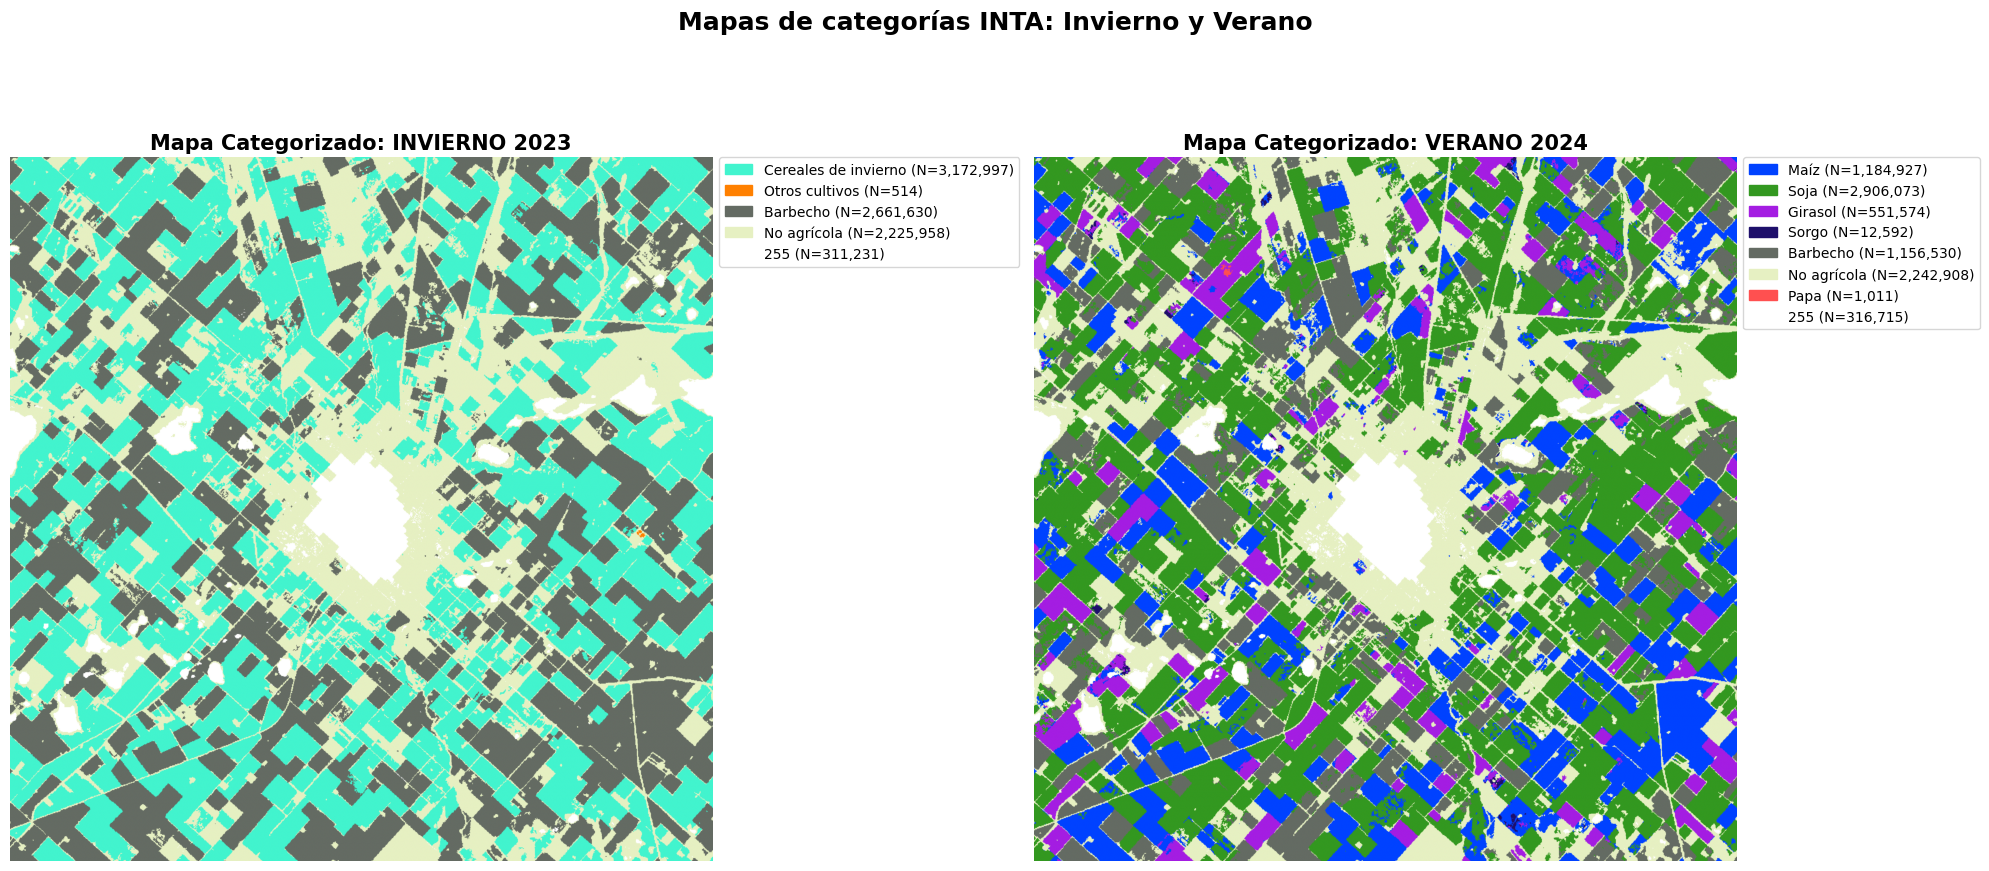


Mapas generados:
  Invierno: 5 categorias presentes de 10 totales
  Verano: 8 categorias presentes de 17 totales

Conteo de píxeles por categoría - INVIERNO:
  Cereales de invierno: 3,172,997 píxeles
  Otros cultivos: 514 píxeles
  Barbecho: 2,661,630 píxeles
  No agrícola: 2,225,958 píxeles
  255: 311,231 píxeles

Conteo de píxeles por categoría - VERANO:
  Maíz: 1,184,927 píxeles
  Soja: 2,906,073 píxeles
  Girasol: 551,574 píxeles
  Sorgo: 12,592 píxeles
  Barbecho: 1,156,530 píxeles
  No agrícola: 2,242,908 píxeles
  Papa: 1,011 píxeles
  255: 316,715 píxeles


In [15]:
# Mapas INTA

# Función para parsear QML y crear colormap
def parsear_qml_para_colormap(qml_path):
    tree = ET.parse(qml_path)
    root = tree.getroot()
    
    vals = []
    labels = []
    hex_colors = []
    
    for it in root.iter('item'):
        label = it.get('label')
        value = it.get('value')
        color = it.get('color')
        if label and value:
            vals.append(int(float(value)))
            labels.append(label)
            
            if color is None:
                hex_colors.append("#888888")
            elif color.startswith("#"):
                hex_colors.append(color)
            elif "," in color:
                rgb_split = color.split(",")
                try:
                    rgb = tuple(map(int, rgb_split[:3]))
                    hex_colors.append('#{:02x}{:02x}{:02x}'.format(*rgb))
                except:
                    hex_colors.append("#888888")
            else:
                hex_colors.append("#888888")
    
    # Ordenar por valor
    z = sorted(zip(vals, hex_colors, labels), key=lambda t: t[0])
    vals, hex_colors, labels = [list(x) for x in zip(*z)]
    
    # Para BoundaryNorm
    boundaries = vals + [vals[-1] + 1]
    cmap = ListedColormap(hex_colors)
    norm = BoundaryNorm(boundaries, ncolors=len(hex_colors))
    
    return vals, hex_colors, labels, cmap, norm

# Parsear QMLs
vals_inv, hex_colors_inv, labels_inv, cmap_inv, norm_inv = parsear_qml_para_colormap(qml_path_inv)
vals_ver, hex_colors_ver, labels_ver, cmap_ver, norm_ver = parsear_qml_para_colormap(qml_path_ver)

# Leer el raster
print("Leyendo raster 9_NDVI_con_recortes.tif...")
with rasterio.open(raster_path) as src:
    # Leer banda 1 (invierno) y banda 2 (verano)
    banda_invierno = src.read(1)
    banda_verano = src.read(2)
    
    # Obtener extent
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
    
    print(f"Dimensiones: {src.height} x {src.width}")
    print(f"CRS: {src.crs}")

# Contar píxeles por categoría para INVIERNO
conteo_inv = {}
for i, cat_val in enumerate(vals_inv):
    mask = (banda_invierno == cat_val)
    n_pixeles = np.sum(mask)
    conteo_inv[cat_val] = n_pixeles

# Contar píxeles por categoría para VERANO
conteo_ver = {}
for i, cat_val in enumerate(vals_ver):
    mask = (banda_verano == cat_val)
    n_pixeles = np.sum(mask)
    conteo_ver[cat_val] = n_pixeles

# Crear leyendas solo con categorías que tienen píxeles > 0
handles_inv = []
for i, cat_val in enumerate(vals_inv):
    n_pixeles = conteo_inv[cat_val]
    if n_pixeles > 0:
        label = f"{labels_inv[i]} (N={n_pixeles:,})"
        handles_inv.append(mpatches.Patch(color=hex_colors_inv[i], label=label))

handles_ver = []
for i, cat_val in enumerate(vals_ver):
    n_pixeles = conteo_ver[cat_val]
    if n_pixeles > 0:
        label = f"{labels_ver[i]} (N={n_pixeles:,})"
        handles_ver.append(mpatches.Patch(color=hex_colors_ver[i], label=label))

# Crear visualización 1 fila y 2 columnas
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Subplot izquierdo: INVIERNO
ax_inv = axes[0]
im_inv = ax_inv.imshow(banda_invierno, cmap=cmap_inv, norm=norm_inv, extent=extent, origin='upper')
ax_inv.set_title("Mapa Categorizado: INVIERNO 2023", fontsize=15, fontweight='bold')
ax_inv.axis("off")

# Leyenda para invierno (solo categorías con píxeles > 0)
ax_inv.legend(handles=handles_inv, bbox_to_anchor=(1.01, 1), loc='upper left', 
              borderaxespad=0., fontsize=10)

# Subplot derecho: VERANO
ax_ver = axes[1]
im_ver = ax_ver.imshow(banda_verano, cmap=cmap_ver, norm=norm_ver, extent=extent, origin='upper')
ax_ver.set_title("Mapa Categorizado: VERANO 2024", fontsize=15, fontweight='bold')
ax_ver.axis("off")

# Leyenda para verano (solo categorías con píxeles > 0)
ax_ver.legend(handles=handles_ver, bbox_to_anchor=(1.01, 1), loc='upper left', 
              borderaxespad=0., fontsize=10)

plt.suptitle("Mapas de categorías INTA: Invierno y Verano", fontsize=18, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

# Imprimir resumen de categorías
categorias_inv_presentes = [cat for cat, n in conteo_inv.items() if n > 0]
categorias_ver_presentes = [cat for cat, n in conteo_ver.items() if n > 0]

print(f"\nMapas generados:")
print(f"  Invierno: {len(categorias_inv_presentes)} categorias presentes de {len(vals_inv)} totales")
print(f"  Verano: {len(categorias_ver_presentes)} categorias presentes de {len(vals_ver)} totales")
print(f"\nConteo de píxeles por categoría - INVIERNO:")
for cat_val in sorted(categorias_inv_presentes):
    idx = vals_inv.index(cat_val)
    print(f"  {labels_inv[idx]}: {conteo_inv[cat_val]:,} píxeles")
print(f"\nConteo de píxeles por categoría - VERANO:")
for cat_val in sorted(categorias_ver_presentes):
    idx = vals_ver.index(cat_val)
    print(f"  {labels_ver[idx]}: {conteo_ver[cat_val]:,} píxeles")


A partir de estos mapas categorizados del INTA de invierno y verano, se observa que la segmentación permite distinguir campos agrícolas con cultivos, barbechos y otras coberturas. Sin embargo, para un próximo modelado donde el objetivo sea clasificar "campo agrícola" versus "campo barbecho" versus "campo no agrícola", seria conveniente agrupar las categorías según sus funciones productivas y uso del suelo real observadas en el gráfico:

- **Campo de cultivo agrícola:** Agrupar todas las clases asociadas a cultivos. Por ejemplo: "Trigo", "Soja", "Maíz", "Cebada", "Otros cultivos", etc.
- **Campo barbecho:** Solo hay una categoría
- **Campo no agrícola:** Para esta clase conviene agrupar no agricola y 255 (No Data)

# Visualizaciones para comparar NDVI

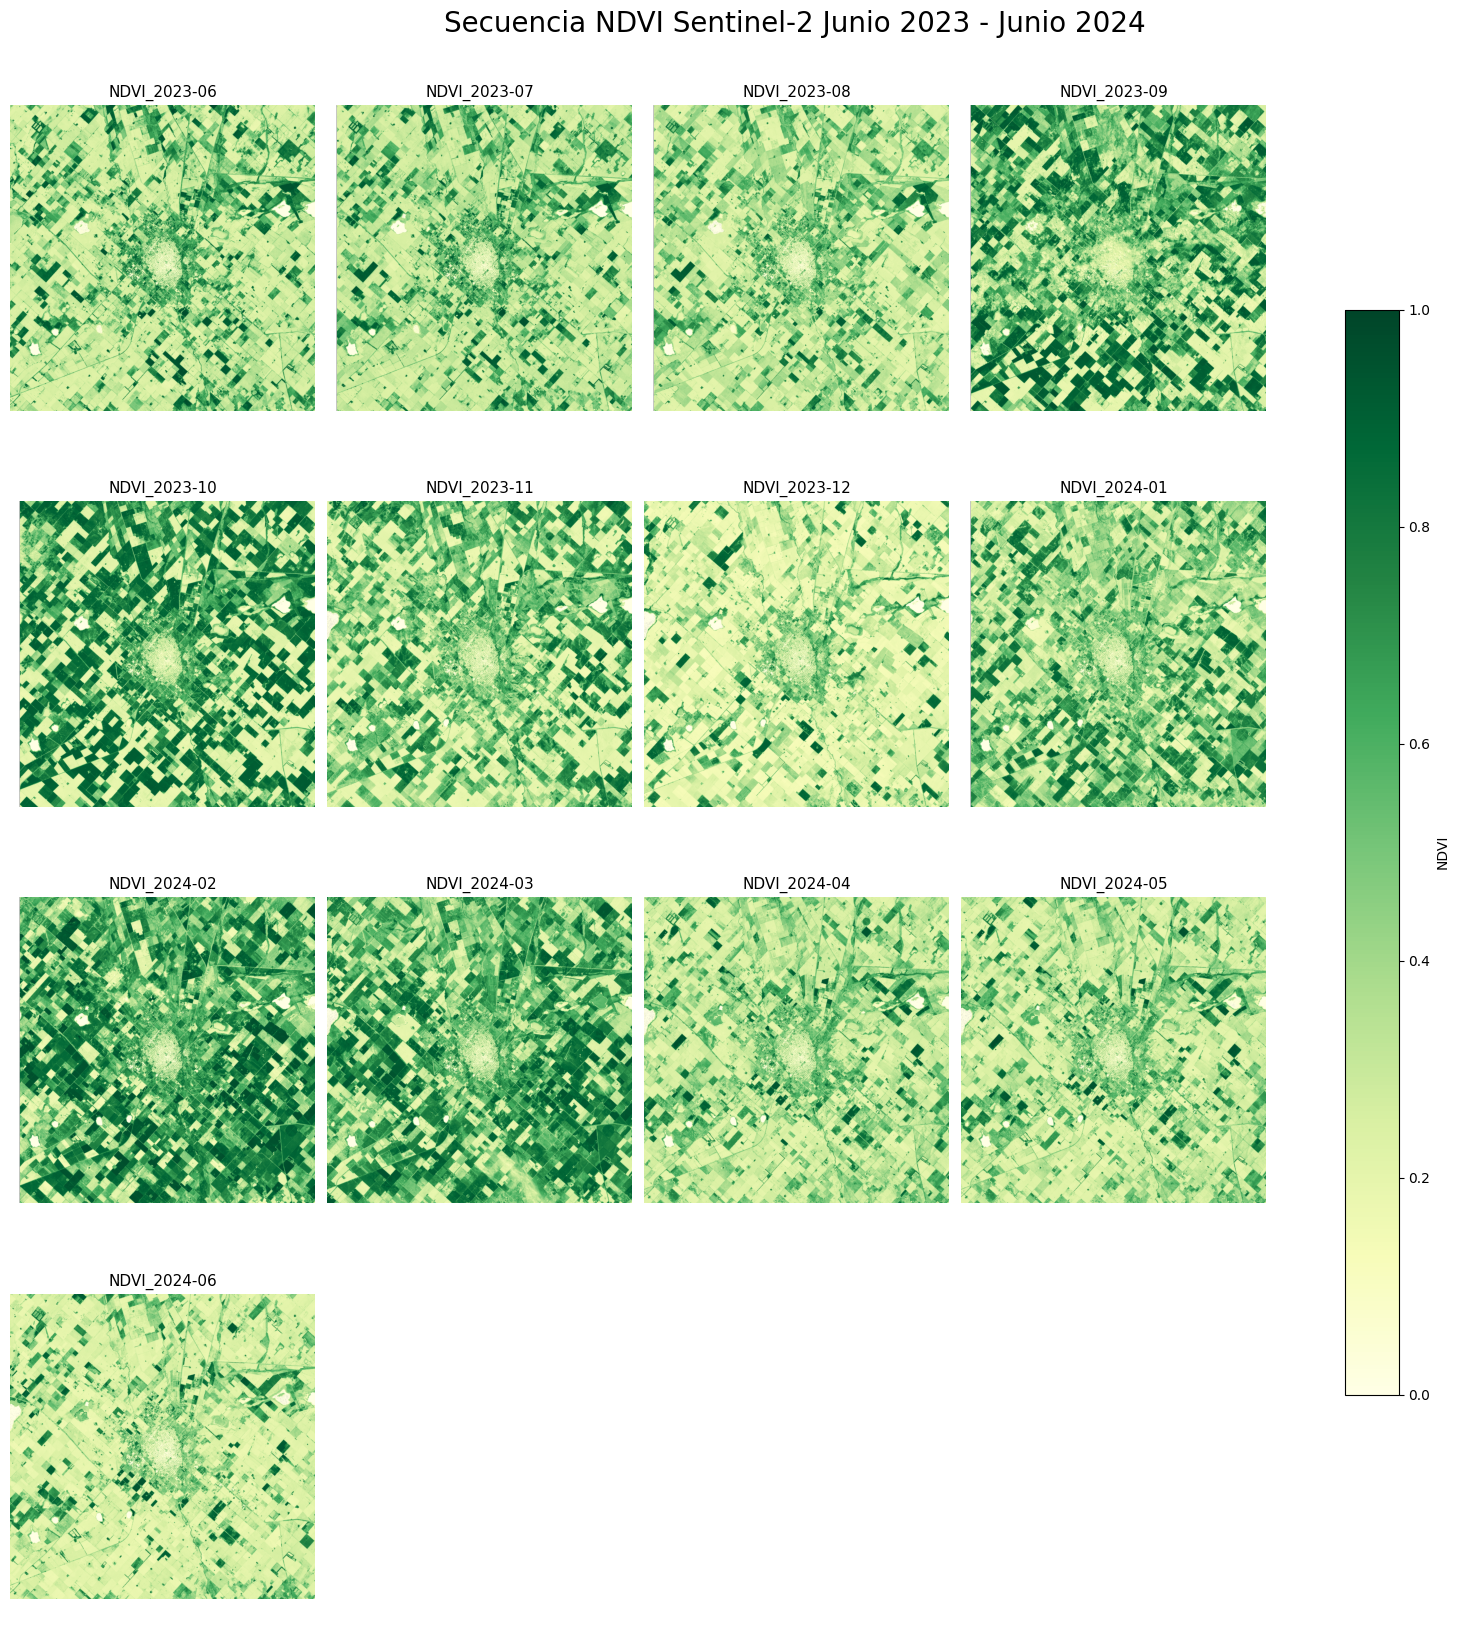

In [16]:
# Visualizacion de todos los NDVI

# Secuencia exacta de archivos .tif según la imagen
archivos = [
    "NDVI_2023-06.tif",
    "NDVI_2023-07.tif",
    "NDVI_2023-08.tif",
    "NDVI_2023-09.tif",
    "NDVI_2023-10.tif",
    "NDVI_2023-11.tif",
    "NDVI_2023-12.tif",
    "NDVI_2024-01.tif",
    "NDVI_2024-02.tif",
    "NDVI_2024-03.tif",
    "NDVI_2024-04.tif",
    "NDVI_2024-05.tif",
    "NDVI_2024-06.tif",
]

n = len(archivos)
ncols = 4
nrows = (n + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))

for idx, archivo in enumerate(archivos):
    fpath = os.path.join(data_dir, archivo)
    row, col = divmod(idx, ncols)
    ax = axes[row, col] if nrows > 1 else axes[col]
    with rasterio.open(fpath) as src:
        img = src.read(1)
        img[img == src.nodata] = None
        im = ax.imshow(img, cmap="YlGn", vmin=0, vmax=1)
    ax.set_title(archivo.split('.')[0], fontsize=11)
    ax.axis("off")

# Si hay ejes vacíos, desactivarlos
for i in range(n, nrows*ncols):
    row, col = divmod(i, ncols)
    ax = axes[row, col] if nrows > 1 else axes[col]
    ax.axis("off")

plt.tight_layout()
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.7, label='NDVI')
plt.suptitle("Secuencia NDVI Sentinel-2 Junio 2023 - Junio 2024", fontsize=20, y=1.02)
plt.show()


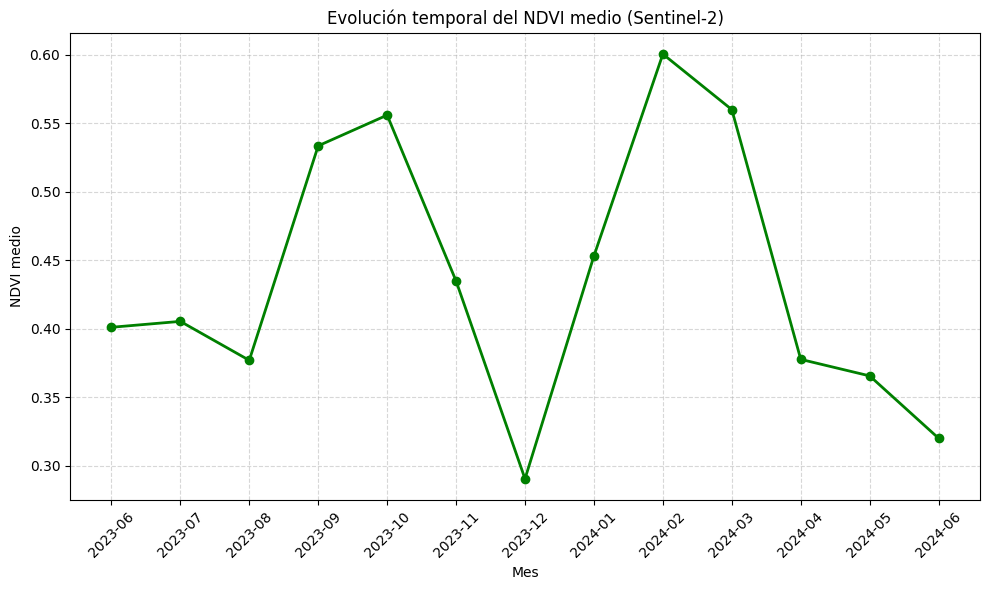

In [17]:
# Evolución Temporal
ndvi_means = []
meses = [
    "2023-06", "2023-07", "2023-08", "2023-09", "2023-10", "2023-11", "2023-12",
    "2024-01", "2024-02", "2024-03", "2024-04", "2024-05", "2024-06"
]

for archivo in archivos:
    fpath = os.path.join(data_dir, archivo)
    with rasterio.open(fpath) as src:
        img = src.read(1)
        # Enmascara nodata (que se puso como None antes)
        if src.nodata is not None:
            mask = img != src.nodata
            ndvi_mean = img[mask].mean()
        else:
            ndvi_mean = np.nanmean(img)
        ndvi_means.append(ndvi_mean)

# Graficar
plt.figure(figsize=(10,6))
plt.plot(meses, ndvi_means, marker='o', color='green', linewidth=2)
plt.xticks(rotation=45)
plt.xlabel("Mes")
plt.ylabel("NDVI medio")
plt.title("Evolución temporal del NDVI medio (Sentinel-2)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Leyendo raster 9_NDVI_con_recortes.tif...
Dimensiones: 2897 x 2890


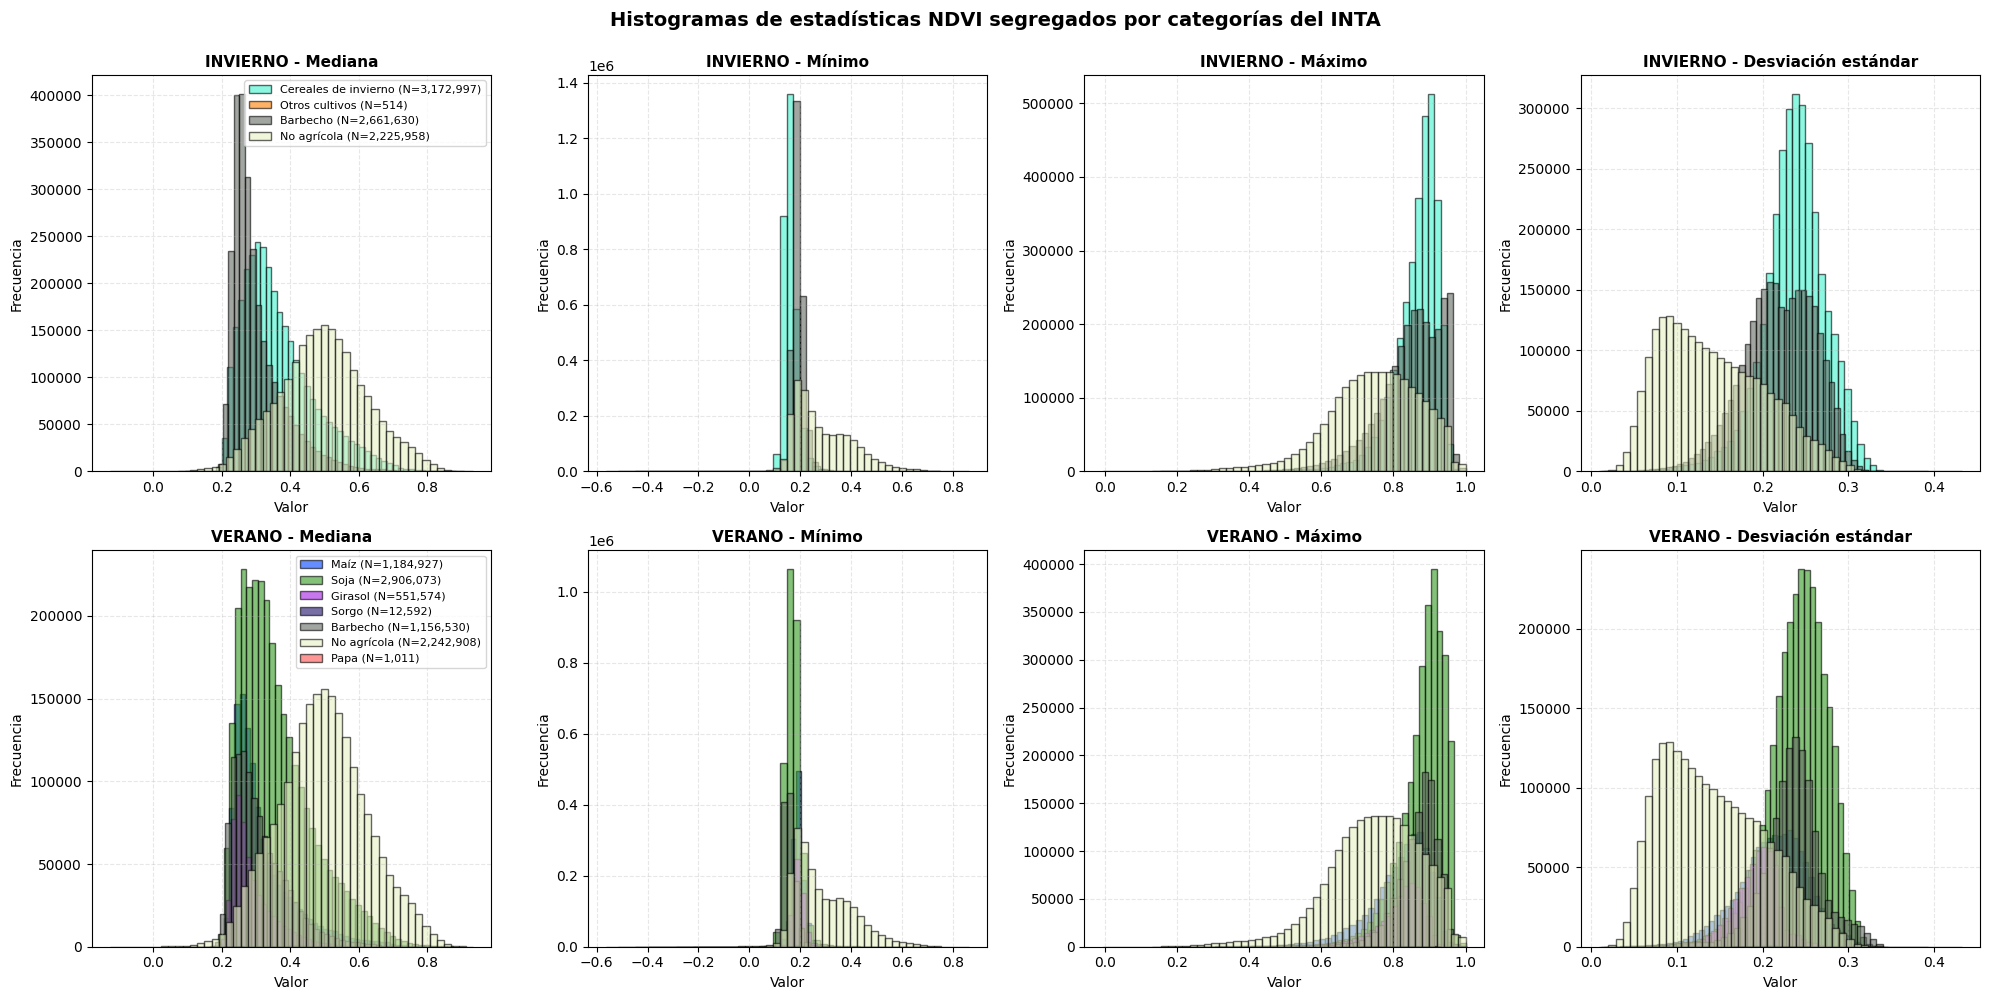

In [24]:
# Histogramas segregados por categorías del INTA

# Nombres de las bandas estadísticas
nombres_bandas = {
    3: "Mediana",
    4: "Mínimo",
    5: "Máximo",
    6: "Desviación estándar"
}

# Valores a excluir
valores_excluir = [255, 0, 25, 31]

# Leer el raster
print("Leyendo raster 9_NDVI_con_recortes.tif...")
with rasterio.open(raster_path) as src:
    # Leer banda 1 (invierno) y banda 2 (verano)
    banda_invierno = src.read(1)
    banda_verano = src.read(2)
    
    # Leer bandas 3, 4, 5, 6 (estadísticas)
    bandas_estadisticas = {}
    for i in range(3, 7):
        banda = src.read(i)
        # Manejar nodata
        if src.nodata is not None:
            banda = banda.astype(np.float32)
            banda[banda == src.nodata] = np.nan
        else:
            banda = banda.astype(np.float32)
        bandas_estadisticas[i] = banda
    
    print(f"Dimensiones: {src.height} x {src.width}")

# Identificar categorías presentes en INVIERNO
categorias_presentes_inv = {}
for cat_val in vals_inv:
    if cat_val not in valores_excluir:
        mask = (banda_invierno == cat_val)
        n_pixeles = np.sum(mask)
        if n_pixeles > 0:
            idx = vals_inv.index(cat_val)
            categorias_presentes_inv[cat_val] = {
                'label': labels_inv[idx],
                'color': hex_colors_inv[idx],
                'n_pixeles': n_pixeles
            }

# Identificar categorías presentes en VERANO
categorias_presentes_ver = {}
for cat_val in vals_ver:
    if cat_val not in valores_excluir:
        mask = (banda_verano == cat_val)
        n_pixeles = np.sum(mask)
        if n_pixeles > 0:
            idx = vals_ver.index(cat_val)
            categorias_presentes_ver[cat_val] = {
                'label': labels_ver[idx],
                'color': hex_colors_ver[idx],
                'n_pixeles': n_pixeles
            }

# Crear visualización 2 filas x 4 columnas
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# Primera fila: INVIERNO
for col_idx, (banda_num, nombre) in enumerate(nombres_bandas.items()):
    ax = axes[0, col_idx]
    datos_estadistica = bandas_estadisticas[banda_num]
    
    # Crear histograma para cada categoría de invierno
    for cat_val in sorted(categorias_presentes_inv.keys()):
        info = categorias_presentes_inv[cat_val]
        mask_categoria = (banda_invierno == cat_val)
        mask_valido = ~np.isnan(datos_estadistica)
        mask_final = mask_categoria & mask_valido
        
        if np.sum(mask_final) > 0:
            datos_categoria = datos_estadistica[mask_final]
            label_con_n = f"{info['label']} (N={info['n_pixeles']:,})"
            ax.hist(datos_categoria, bins=50, alpha=0.6, edgecolor='black', 
                   label=label_con_n, color=info['color'])
    
    ax.set_xlabel("Valor", fontsize=10)
    ax.set_ylabel("Frecuencia", fontsize=10)
    ax.set_title(f"INVIERNO - {nombre}", fontsize=11, fontweight='bold')
    ax.grid(True, linestyle='--', alpha=0.3)
    if col_idx == 0:
        ax.legend(fontsize=8, loc='best')

# Segunda fila: VERANO
for col_idx, (banda_num, nombre) in enumerate(nombres_bandas.items()):
    ax = axes[1, col_idx]
    datos_estadistica = bandas_estadisticas[banda_num]
    
    # Crear histograma para cada categoría de verano
    for cat_val in sorted(categorias_presentes_ver.keys()):
        info = categorias_presentes_ver[cat_val]
        mask_categoria = (banda_verano == cat_val)
        mask_valido = ~np.isnan(datos_estadistica)
        mask_final = mask_categoria & mask_valido
        
        if np.sum(mask_final) > 0:
            datos_categoria = datos_estadistica[mask_final]
            label_con_n = f"{info['label']} (N={info['n_pixeles']:,})"
            ax.hist(datos_categoria, bins=50, alpha=0.6, edgecolor='black', 
                   label=label_con_n, color=info['color'])
    
    ax.set_xlabel("Valor", fontsize=10)
    ax.set_ylabel("Frecuencia", fontsize=10)
    ax.set_title(f"VERANO - {nombre}", fontsize=11, fontweight='bold')
    ax.grid(True, linestyle='--', alpha=0.3)
    if col_idx == 0:
        ax.legend(fontsize=8, loc='best')

plt.suptitle("Histogramas de estadísticas NDVI segregados por categorías del INTA", 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


Leyendo raster 9_NDVI_con_recortes.tif...
Dimensiones: 2897 x 2890


C:\Users\lean3\AppData\Local\Temp\ipykernel_17732\3710344035.py:115: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(datos_para_boxplot, labels=labels_para_boxplot, vert=True,
C:\Users\lean3\AppData\Local\Temp\ipykernel_17732\3710344035.py:115: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(datos_para_boxplot, labels=labels_para_boxplot, vert=True,
C:\Users\lean3\AppData\Local\Temp\ipykernel_17732\3710344035.py:115: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(datos_para_boxplot, labels=labels_para_boxplot, vert=True,
C:\Users\lean3\AppData\Local\Temp\ipykernel_17732\37103

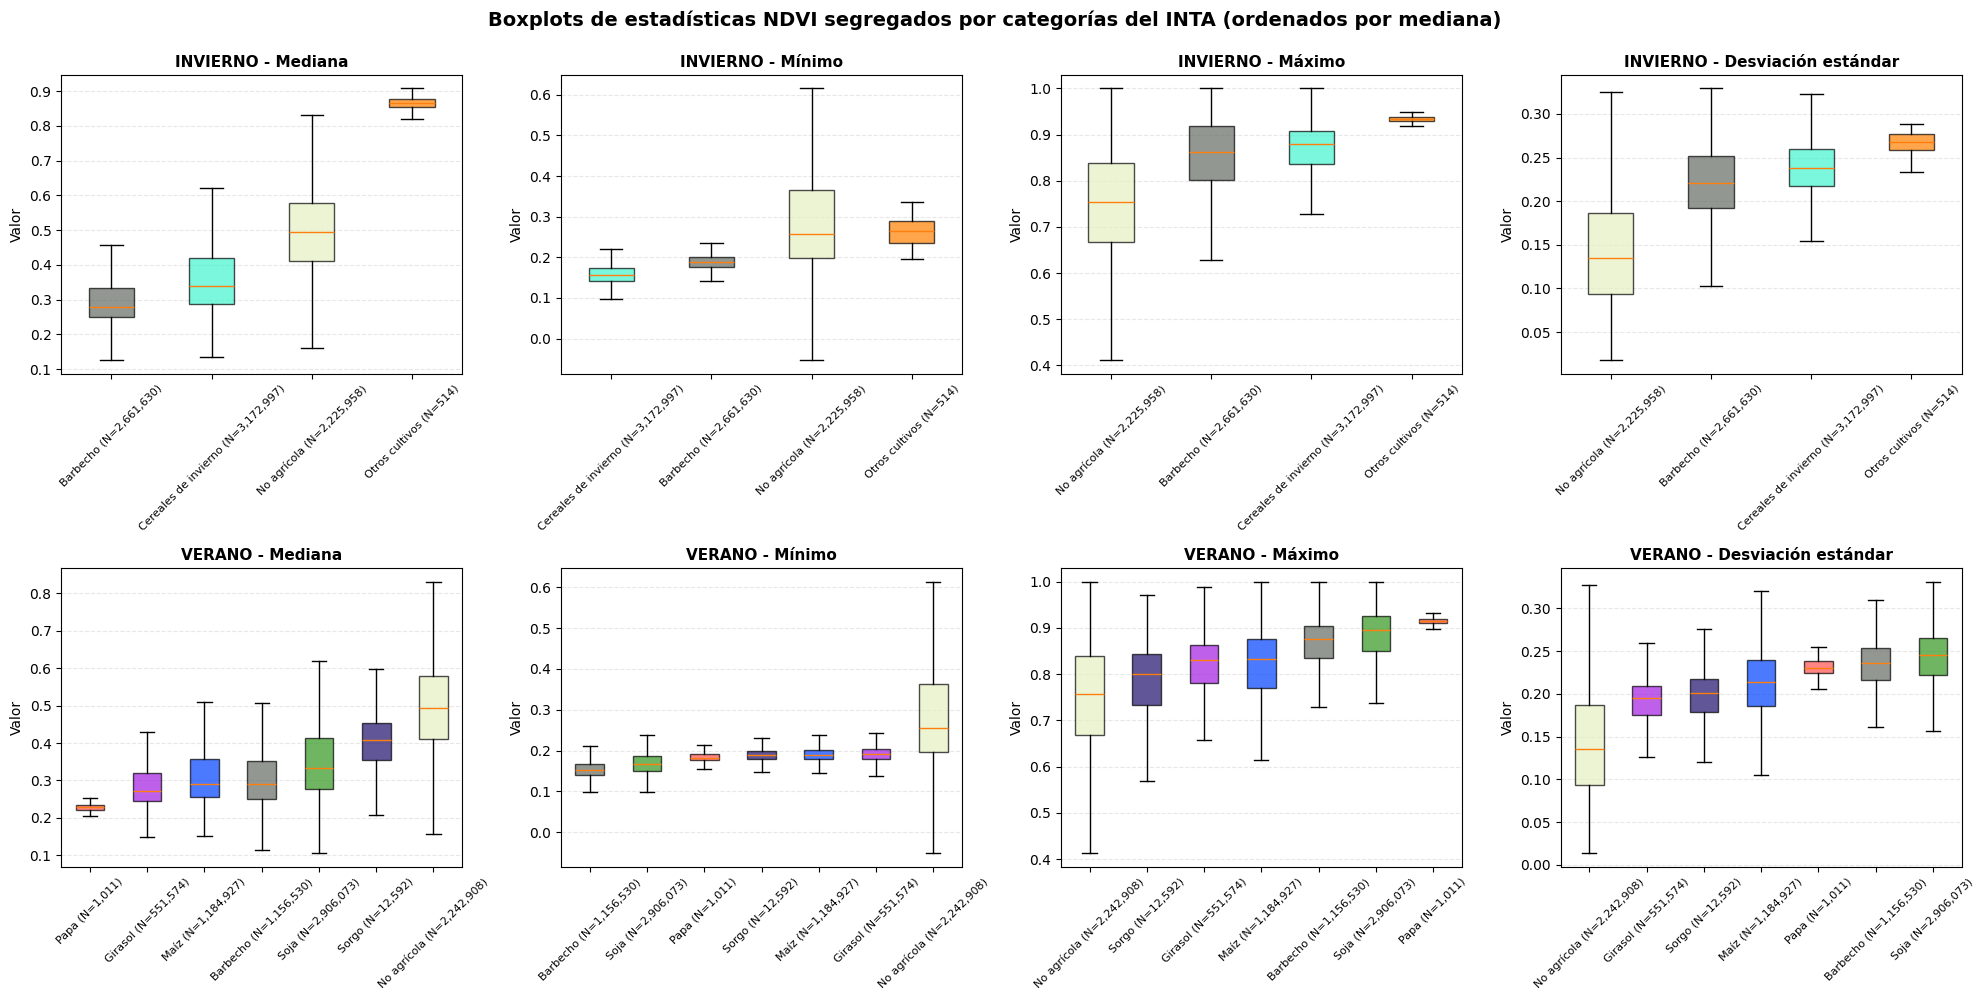

In [25]:
# Boxplots segregados por categorías del INTA (ordenados por mediana)

# Nombres de las bandas estadísticas
nombres_bandas = {
    3: "Mediana",
    4: "Mínimo",
    5: "Máximo",
    6: "Desviación estándar"
}

# Valores a excluir
valores_excluir = [255, 0, 25, 31]

# Leer el raster
print("Leyendo raster 9_NDVI_con_recortes.tif...")
with rasterio.open(raster_path) as src:
    # Leer banda 1 (invierno) y banda 2 (verano)
    banda_invierno = src.read(1)
    banda_verano = src.read(2)
    
    # Leer bandas 3, 4, 5, 6 (estadísticas)
    bandas_estadisticas = {}
    for i in range(3, 7):
        banda = src.read(i)
        # Manejar nodata
        if src.nodata is not None:
            banda = banda.astype(np.float32)
            banda[banda == src.nodata] = np.nan
        else:
            banda = banda.astype(np.float32)
        bandas_estadisticas[i] = banda
    
    print(f"Dimensiones: {src.height} x {src.width}")

# Identificar categorías presentes en INVIERNO
categorias_presentes_inv = {}
for cat_val in vals_inv:
    if cat_val not in valores_excluir:
        mask = (banda_invierno == cat_val)
        n_pixeles = np.sum(mask)
        if n_pixeles > 0:
            idx = vals_inv.index(cat_val)
            categorias_presentes_inv[cat_val] = {
                'label': labels_inv[idx],
                'color': hex_colors_inv[idx],
                'n_pixeles': n_pixeles
            }

# Identificar categorías presentes en VERANO
categorias_presentes_ver = {}
for cat_val in vals_ver:
    if cat_val not in valores_excluir:
        mask = (banda_verano == cat_val)
        n_pixeles = np.sum(mask)
        if n_pixeles > 0:
            idx = vals_ver.index(cat_val)
            categorias_presentes_ver[cat_val] = {
                'label': labels_ver[idx],
                'color': hex_colors_ver[idx],
                'n_pixeles': n_pixeles
            }

# Función para ordenar categorías por mediana
def ordenar_por_mediana(categorias_presentes, banda_categorias, datos_estadistica):
    medianas = {}
    for cat_val in categorias_presentes.keys():
        mask_categoria = (banda_categorias == cat_val)
        mask_valido = ~np.isnan(datos_estadistica)
        mask_final = mask_categoria & mask_valido
        
        if np.sum(mask_final) > 0:
            datos_categoria = datos_estadistica[mask_final]
            medianas[cat_val] = np.nanmedian(datos_categoria)
        else:
            medianas[cat_val] = np.nan
    
    # Ordenar por mediana (de menor a mayor)
    categorias_ordenadas = sorted(categorias_presentes.keys(), key=lambda x: medianas.get(x, np.nan))
    return categorias_ordenadas

# Crear visualización 2 filas x 4 columnas
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# Primera fila: INVIERNO
for col_idx, (banda_num, nombre) in enumerate(nombres_bandas.items()):
    ax = axes[0, col_idx]
    datos_estadistica = bandas_estadisticas[banda_num]
    
    # Ordenar categorías por mediana
    categorias_ordenadas = ordenar_por_mediana(categorias_presentes_inv, banda_invierno, datos_estadistica)
    
    # Preparar datos para boxplot
    datos_para_boxplot = []
    labels_para_boxplot = []
    colores_para_boxplot = []
    
    for cat_val in categorias_ordenadas:
        info = categorias_presentes_inv[cat_val]
        mask_categoria = (banda_invierno == cat_val)
        mask_valido = ~np.isnan(datos_estadistica)
        mask_final = mask_categoria & mask_valido
        
        if np.sum(mask_final) > 0:
            datos_categoria = datos_estadistica[mask_final]
            # Muestrear si hay demasiados datos para el boxplot
            if len(datos_categoria) > 100000:
                datos_categoria = np.random.choice(datos_categoria, size=100000, replace=False)
            datos_para_boxplot.append(datos_categoria)
            label_con_n = f"{info['label']} (N={info['n_pixeles']:,})"
            labels_para_boxplot.append(label_con_n)
            colores_para_boxplot.append(info['color'])
    
    # Crear boxplot
    if datos_para_boxplot:
        bp = ax.boxplot(datos_para_boxplot, labels=labels_para_boxplot, vert=True, 
                       patch_artist=True, showfliers=False)
        
        # Aplicar colores
        for patch, color in zip(bp['boxes'], colores_para_boxplot):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
    
    ax.set_ylabel("Valor", fontsize=10)
    ax.set_title(f"INVIERNO - {nombre}", fontsize=11, fontweight='bold')
    ax.grid(True, linestyle='--', alpha=0.3, axis='y')
    ax.tick_params(axis='x', rotation=45, labelsize=8)

# Segunda fila: VERANO
for col_idx, (banda_num, nombre) in enumerate(nombres_bandas.items()):
    ax = axes[1, col_idx]
    datos_estadistica = bandas_estadisticas[banda_num]
    
    # Ordenar categorías por mediana
    categorias_ordenadas = ordenar_por_mediana(categorias_presentes_ver, banda_verano, datos_estadistica)
    
    # Preparar datos para boxplot
    datos_para_boxplot = []
    labels_para_boxplot = []
    colores_para_boxplot = []
    
    for cat_val in categorias_ordenadas:
        info = categorias_presentes_ver[cat_val]
        mask_categoria = (banda_verano == cat_val)
        mask_valido = ~np.isnan(datos_estadistica)
        mask_final = mask_categoria & mask_valido
        
        if np.sum(mask_final) > 0:
            datos_categoria = datos_estadistica[mask_final]
            # Muestrear si hay demasiados datos para el boxplot
            if len(datos_categoria) > 100000:
                datos_categoria = np.random.choice(datos_categoria, size=100000, replace=False)
            datos_para_boxplot.append(datos_categoria)
            label_con_n = f"{info['label']} (N={info['n_pixeles']:,})"
            labels_para_boxplot.append(label_con_n)
            colores_para_boxplot.append(info['color'])
    
    # Crear boxplot
    if datos_para_boxplot:
        bp = ax.boxplot(datos_para_boxplot, labels=labels_para_boxplot, vert=True, 
                       patch_artist=True, showfliers=False)
        
        # Aplicar colores
        for patch, color in zip(bp['boxes'], colores_para_boxplot):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
    
    ax.set_ylabel("Valor", fontsize=10)
    ax.set_title(f"VERANO - {nombre}", fontsize=11, fontweight='bold')
    ax.grid(True, linestyle='--', alpha=0.3, axis='y')
    ax.tick_params(axis='x', rotation=45, labelsize=8)

plt.suptitle("Boxplots de estadísticas NDVI segregados por categorías del INTA (ordenados por mediana)", 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


Leyendo raster 9_NDVI_con_recortes.tif...
Dimensiones: 2897 x 2890

Categorías presentes en INVIERNO: 4
  Cereales de invierno (valor=16, píxeles=3,172,997)
  Otros cultivos (valor=17, píxeles=514)
  Barbecho (valor=18, píxeles=2,661,630)
  No agrícola (valor=20, píxeles=2,225,958)

Categorías presentes en VERANO: 7
  Maíz (valor=10, píxeles=1,184,927)
  Soja (valor=11, píxeles=2,906,073)
  Girasol (valor=12, píxeles=551,574)
  Sorgo (valor=18, píxeles=12,592)
  Barbecho (valor=21, píxeles=1,156,530)
  No agrícola (valor=22, píxeles=2,242,908)
  Papa (valor=26, píxeles=1,011)


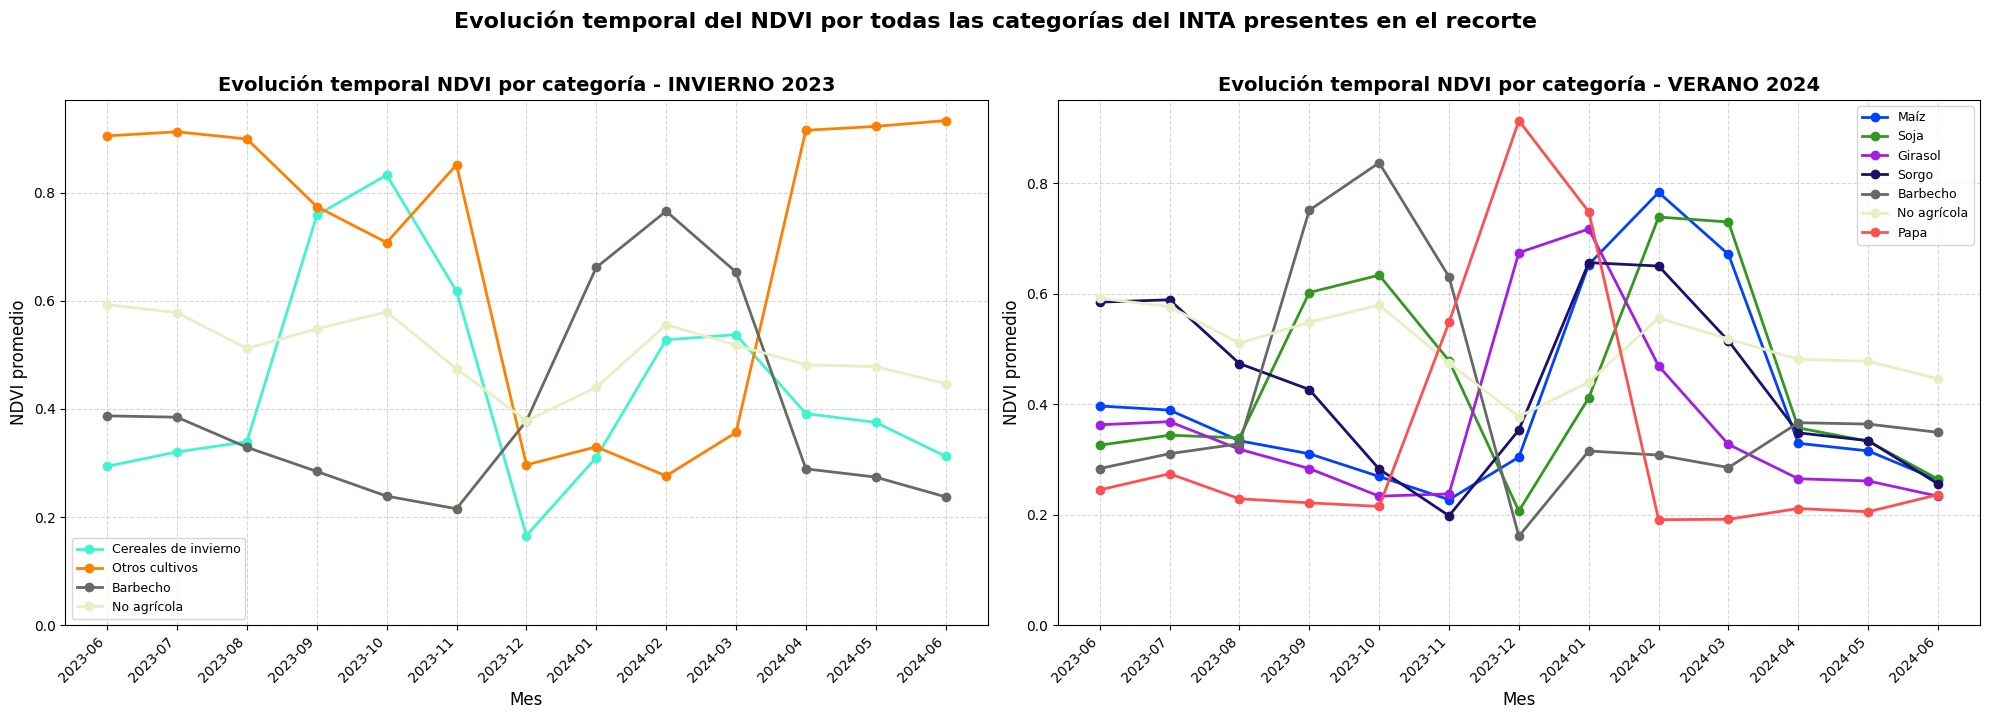


Graficos generados exitosamente con todas las categorías individuales


In [19]:
# Evolución temporal del NDVI por todas las categorías individuales del INTA

# Meses correspondientes a las bandas 7-19 (NDVI temporal)
meses = [
    "2023-06", "2023-07", "2023-08", "2023-09", "2023-10", "2023-11", "2023-12",
    "2024-01", "2024-02", "2024-03", "2024-04", "2024-05", "2024-06"
]

# Leer el raster para obtener bandas NDVI
print("Leyendo raster 9_NDVI_con_recortes.tif...")
with rasterio.open(raster_path) as src:
    # Leer banda 1 (invierno) y banda 2 (verano)
    banda_invierno = src.read(1)
    banda_verano = src.read(2)
    
    # Leer bandas 7-19 (NDVI temporal)
    bandas_ndvi = []
    for i in range(7, 20):  # Bandas 7 a 19
        banda = src.read(i)
        if src.nodata is not None:
            banda = banda.astype(np.float32)
            banda[banda == src.nodata] = np.nan
        else:
            banda = banda.astype(np.float32)
        bandas_ndvi.append(banda)
    
    print(f"Dimensiones: {src.height} x {src.width}")

# Identificar categorías presentes en el recorte (excluyendo valores especiales)
valores_excluir = [255, 0, 25, 31]  # Excluir nodata, máscara y otros valores especiales

# Obtener categorías presentes en INVIERNO
categorias_presentes_inv = {}
for cat_val in vals_inv:
    if cat_val not in valores_excluir:
        mask = (banda_invierno == cat_val)
        n_pixeles = np.sum(mask)
        if n_pixeles > 0:
            idx = vals_inv.index(cat_val)
            categorias_presentes_inv[cat_val] = {
                'label': labels_inv[idx],
                'color': hex_colors_inv[idx],
                'n_pixeles': n_pixeles
            }

# Obtener categorías presentes en VERANO
categorias_presentes_ver = {}
for cat_val in vals_ver:
    if cat_val not in valores_excluir:
        mask = (banda_verano == cat_val)
        n_pixeles = np.sum(mask)
        if n_pixeles > 0:
            idx = vals_ver.index(cat_val)
            categorias_presentes_ver[cat_val] = {
                'label': labels_ver[idx],
                'color': hex_colors_ver[idx],
                'n_pixeles': n_pixeles
            }

print(f"\nCategorías presentes en INVIERNO: {len(categorias_presentes_inv)}")
for cat_val, info in sorted(categorias_presentes_inv.items()):
    print(f"  {info['label']} (valor={cat_val}, píxeles={info['n_pixeles']:,})")

print(f"\nCategorías presentes en VERANO: {len(categorias_presentes_ver)}")
for cat_val, info in sorted(categorias_presentes_ver.items()):
    print(f"  {info['label']} (valor={cat_val}, píxeles={info['n_pixeles']:,})")

# Función para calcular NDVI promedio por categoría individual
def calcular_ndvi_por_categoria(banda_categorias, bandas_ndvi, categorias_presentes):
    resultados = defaultdict(list)
    
    for idx_mes, banda_ndvi in enumerate(bandas_ndvi):
        for cat_val, info in categorias_presentes.items():
            # Máscara: píxeles de esta categoría Y válidos en NDVI
            mask_categoria = (banda_categorias == cat_val)
            mask_valido = ~np.isnan(banda_ndvi)
            mask_final = mask_categoria & mask_valido
            
            if np.sum(mask_final) > 0:
                ndvi_promedio = np.nanmean(banda_ndvi[mask_final])
            else:
                ndvi_promedio = np.nan
            
            resultados[cat_val].append(ndvi_promedio)
    
    return resultados

# Calcular NDVI por categoría para INVIERNO
ndvi_por_categoria_inv = calcular_ndvi_por_categoria(banda_invierno, bandas_ndvi, categorias_presentes_inv)

# Calcular NDVI por categoría para VERANO
ndvi_por_categoria_ver = calcular_ndvi_por_categoria(banda_verano, bandas_ndvi, categorias_presentes_ver)

# Crear visualización 1 fila y 2 columnas
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

# Subplot izquierdo: INVIERNO
ax_inv = axes[0]
for cat_val in sorted(categorias_presentes_inv.keys()):
    valores_ndvi = ndvi_por_categoria_inv[cat_val]
    info = categorias_presentes_inv[cat_val]
    color = info['color']
    label = info['label']
    
    if any(not np.isnan(v) for v in valores_ndvi):
        ax_inv.plot(meses, valores_ndvi, marker='o', label=label, 
                   color=color, linewidth=2, markersize=6)

ax_inv.set_xticks(range(len(meses)))
ax_inv.set_xticklabels(meses, rotation=45, ha='right')
ax_inv.set_xlabel("Mes", fontsize=12)
ax_inv.set_ylabel("NDVI promedio", fontsize=12)
ax_inv.set_title("Evolución temporal NDVI por categoría - INVIERNO 2023", 
                fontsize=14, fontweight='bold')
ax_inv.grid(True, linestyle='--', alpha=0.5)
ax_inv.legend(fontsize=9, loc='best', ncol=1)
ax_inv.set_ylim(bottom=0)

# Subplot derecho: VERANO
ax_ver = axes[1]
for cat_val in sorted(categorias_presentes_ver.keys()):
    valores_ndvi = ndvi_por_categoria_ver[cat_val]
    info = categorias_presentes_ver[cat_val]
    color = info['color']
    label = info['label']
    
    if any(not np.isnan(v) for v in valores_ndvi):
        ax_ver.plot(meses, valores_ndvi, marker='o', label=label, 
                   color=color, linewidth=2, markersize=6)

ax_ver.set_xticks(range(len(meses)))
ax_ver.set_xticklabels(meses, rotation=45, ha='right')
ax_ver.set_xlabel("Mes", fontsize=12)
ax_ver.set_ylabel("NDVI promedio", fontsize=12)
ax_ver.set_title("Evolución temporal NDVI por categoría - VERANO 2024", 
                fontsize=14, fontweight='bold')
ax_ver.grid(True, linestyle='--', alpha=0.5)
ax_ver.legend(fontsize=9, loc='best', ncol=1)
ax_ver.set_ylim(bottom=0)

plt.suptitle("Evolución temporal del NDVI por todas las categorías del INTA presentes en el recorte", 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f"\nGraficos generados exitosamente con todas las categorías individuales")


Grupos INVIERNO:
  Barbecho: [18]
  No agrícola: [20]
  Cultivos: [6, 16, 17, 19, 24, 26]

Grupos VERANO:
  Barbecho: [21]
  No agrícola: [22]
  Cultivos: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 26, 28, 30]

Leyendo raster 9_NDVI_con_recortes.tif...
Dimensiones: 2897 x 2890


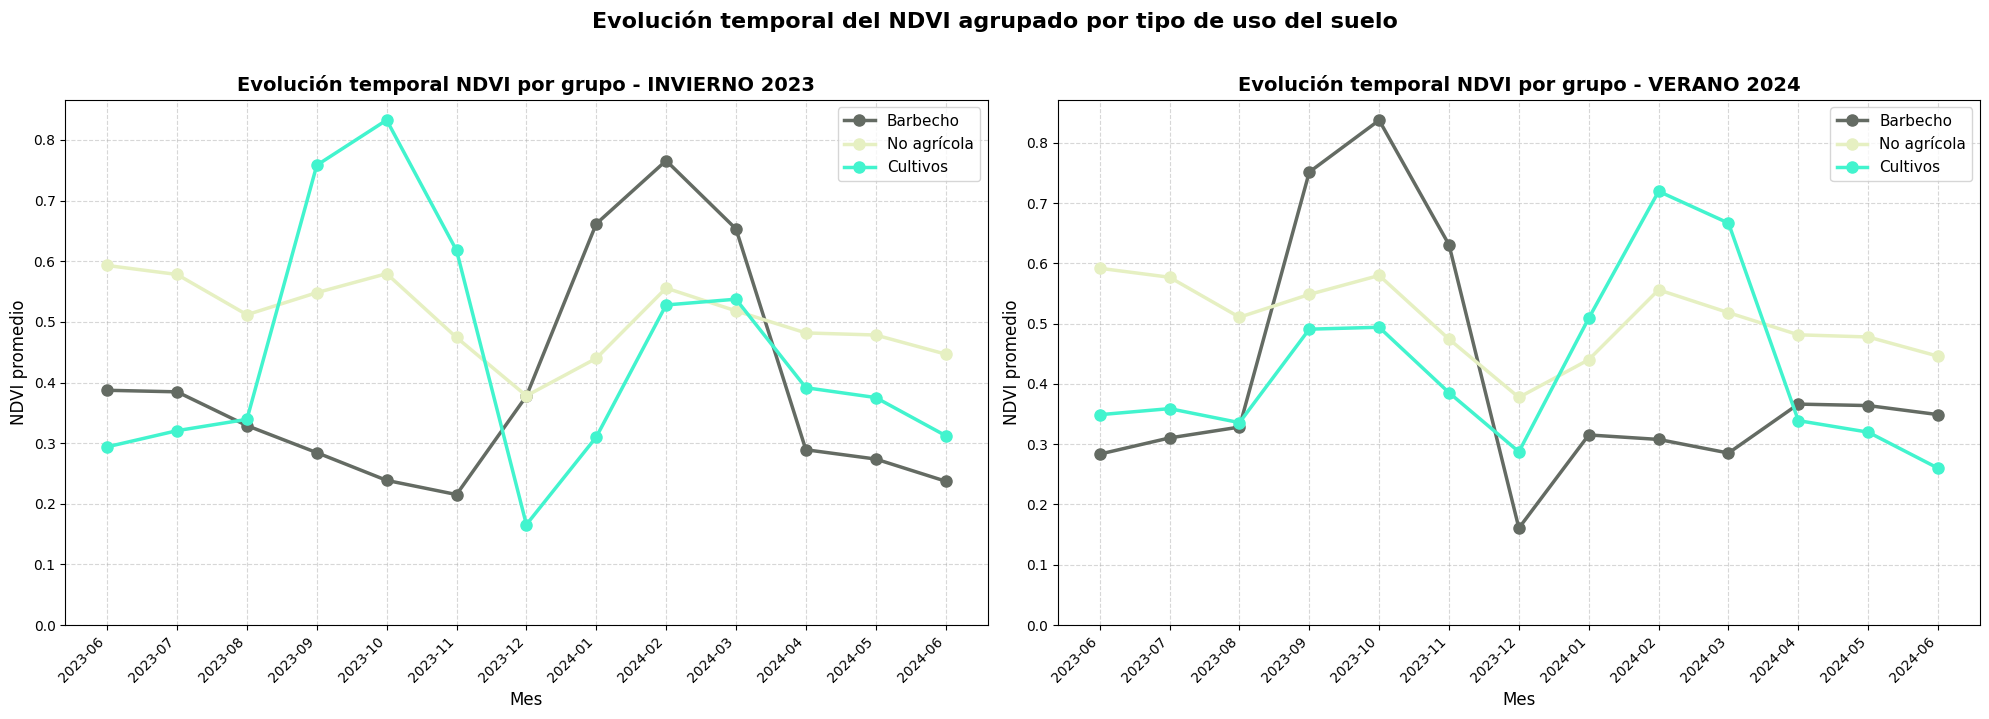


Graficos generados exitosamente


In [20]:
# Usar paths definidos en la celda 6

# Meses correspondientes a las bandas 7-19 (NDVI temporal)
meses = [
    "2023-06", "2023-07", "2023-08", "2023-09", "2023-10", "2023-11", "2023-12",
    "2024-01", "2024-02", "2024-03", "2024-04", "2024-05", "2024-06"
]

# Función para parsear QML y obtener categorías
def parsear_categorias_qml(qml_path):
    tree = ET.parse(qml_path)
    root = tree.getroot()
    
    categorias = {}
    for it in root.iter('item'):
        label = it.get('label')
        value = it.get('value')
        if label and value:
            cat_val = int(float(value))
            categorias[cat_val] = label
    
    return categorias

# Parsear categorías
categorias_inv = parsear_categorias_qml(qml_path_inv)
categorias_ver = parsear_categorias_qml(qml_path_ver)

# Definir grupos para INVIERNO
barbecho_inv = [18]  # Barbecho
no_agricola_inv = [20]  # No agrícola
# Todos los demás son cultivos
cultivos_inv = [cat for cat in categorias_inv.keys() 
                if cat not in barbecho_inv + no_agricola_inv + [25, 255]]  # Excluir Máscara y 255

# Definir grupos para VERANO
barbecho_ver = [21]  # Barbecho
no_agricola_ver = [22]  # No agrícola
# Todos los demás son cultivos
cultivos_ver = [cat for cat in categorias_ver.keys() 
                if cat not in barbecho_ver + no_agricola_ver + [31, 255]]  # Excluir Máscara y 255

print("Grupos INVIERNO:")
print(f"  Barbecho: {barbecho_inv}")
print(f"  No agrícola: {no_agricola_inv}")
print(f"  Cultivos: {cultivos_inv}")

print("\nGrupos VERANO:")
print(f"  Barbecho: {barbecho_ver}")
print(f"  No agrícola: {no_agricola_ver}")
print(f"  Cultivos: {cultivos_ver}")

# Leer el raster
print("\nLeyendo raster 9_NDVI_con_recortes.tif...")
with rasterio.open(raster_path) as src:
    # Leer banda 1 (invierno) y banda 2 (verano)
    banda_invierno = src.read(1)
    banda_verano = src.read(2)
    
    # Leer bandas 7-19 (NDVI temporal)
    bandas_ndvi = []
    for i in range(7, 20):  # Bandas 7 a 19
        banda = src.read(i)
        if src.nodata is not None:
            banda = banda.astype(np.float32)
            banda[banda == src.nodata] = np.nan
        else:
            banda = banda.astype(np.float32)
        bandas_ndvi.append(banda)
    
    print(f"Dimensiones: {src.height} x {src.width}")

# Función para calcular NDVI promedio por grupo
def calcular_ndvi_por_grupo(banda_categorias, bandas_ndvi, grupos, nombre_grupo):
    resultados = defaultdict(list)
    
    for idx_mes, banda_ndvi in enumerate(bandas_ndvi):
        for grupo_nombre, categorias_grupo in grupos.items():
            # Crear máscara para todas las categorías del grupo
            mask_grupo = np.zeros_like(banda_categorias, dtype=bool)
            for cat_val in categorias_grupo:
                mask_grupo |= (banda_categorias == cat_val)
            
            # Máscara para valores válidos de NDVI
            mask_valido = ~np.isnan(banda_ndvi)
            mask_final = mask_grupo & mask_valido
            
            if np.sum(mask_final) > 0:
                ndvi_promedio = np.nanmean(banda_ndvi[mask_final])
            else:
                ndvi_promedio = np.nan
            
            resultados[grupo_nombre].append(ndvi_promedio)
    
    return resultados

# Calcular para INVIERNO
grupos_inv = {
    'Barbecho': barbecho_inv,
    'No agrícola': no_agricola_inv,
    'Cultivos': cultivos_inv
}
ndvi_por_grupo_inv = calcular_ndvi_por_grupo(banda_invierno, bandas_ndvi, grupos_inv, 'invierno')

# Calcular para VERANO
grupos_ver = {
    'Barbecho': barbecho_ver,
    'No agrícola': no_agricola_ver,
    'Cultivos': cultivos_ver
}
ndvi_por_grupo_ver = calcular_ndvi_por_grupo(banda_verano, bandas_ndvi, grupos_ver, 'verano')

# Crear visualización 1 fila y 2 columnas
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

# Colores para los grupos
colores_grupos = {
    'Barbecho': '#646b63',  # Gris
    'No agrícola': '#e6f0c2',  # Beige claro
    'Cultivos': '#42f4ce'  # Verde azulado
}

# Subplot izquierdo: INVIERNO
ax_inv = axes[0]
for grupo_nombre in ['Barbecho', 'No agrícola', 'Cultivos']:
    valores_ndvi = ndvi_por_grupo_inv[grupo_nombre]
    color = colores_grupos[grupo_nombre]
    
    if any(not np.isnan(v) for v in valores_ndvi):
        ax_inv.plot(meses, valores_ndvi, marker='o', label=grupo_nombre, 
                   color=color, linewidth=2.5, markersize=8)

ax_inv.set_xticks(range(len(meses)))
ax_inv.set_xticklabels(meses, rotation=45, ha='right')
ax_inv.set_xlabel("Mes", fontsize=12)
ax_inv.set_ylabel("NDVI promedio", fontsize=12)
ax_inv.set_title("Evolución temporal NDVI por grupo - INVIERNO 2023", 
                fontsize=14, fontweight='bold')
ax_inv.grid(True, linestyle='--', alpha=0.5)
ax_inv.legend(fontsize=11, loc='best')
ax_inv.set_ylim(bottom=0)

# Subplot derecho: VERANO
ax_ver = axes[1]
for grupo_nombre in ['Barbecho', 'No agrícola', 'Cultivos']:
    valores_ndvi = ndvi_por_grupo_ver[grupo_nombre]
    color = colores_grupos[grupo_nombre]
    
    if any(not np.isnan(v) for v in valores_ndvi):
        ax_ver.plot(meses, valores_ndvi, marker='o', label=grupo_nombre, 
                   color=color, linewidth=2.5, markersize=8)

ax_ver.set_xticks(range(len(meses)))
ax_ver.set_xticklabels(meses, rotation=45, ha='right')
ax_ver.set_xlabel("Mes", fontsize=12)
ax_ver.set_ylabel("NDVI promedio", fontsize=12)
ax_ver.set_title("Evolución temporal NDVI por grupo - VERANO 2024", 
                fontsize=14, fontweight='bold')
ax_ver.grid(True, linestyle='--', alpha=0.5)
ax_ver.legend(fontsize=11, loc='best')
ax_ver.set_ylim(bottom=0)

plt.suptitle("Evolución temporal del NDVI agrupado por tipo de uso del suelo", 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f"\nGraficos generados exitosamente")


# Conclusión:

Este ultimo gráfico ilustra la evolución temporal del NDVI agrupado por tipo de uso del suelo, según la clasificación INTA para invierno y verano. Un hallazgo importante es que la utilidad de la clasificación de INTA ("Barbecho", "No agrícola" y "Cultivos") basada en la estación solo es válida si se analizan los meses correspondientes a cada temporada. Se observa que la clase "Barbecho" presenta un pico significativo de NDVI fuera de la estación en la que el INTA lo clasifica como tal; por ejemplo, **se detecta un aumento de NDVI durante el verano en los píxeles clasificados como barbecho de invierno**, y un comportamiento análogo ocurre en los píxeles clasificados como barbecho de verano durante los meses de invierno.

Este comportamiento indica que los píxeles identificados como barbecho solo cumplen con dicha categoría durante la estación asignada por INTA, mientras que en el resto del ciclo agrícola pueden corresponder a otros usos del suelo, generalmente cultivos. Es un indicio fuerte de que la dinámica del uso del suelo no es fija a lo largo del año, lo que complica el desarrollo de modelos de clasificación o predicción. Si se entrena un clasificador de usos del suelo utilizando toda la serie temporal sin tener en cuenta la estacionalidad, el modelo probablemente identificará erróneamente los píxeles que cambian de uso entre estaciones, dado que la misma localización presenta firmas espectrales muy diferentes según la época del año.
 
Este problema lo podriamos solucionar dividiendo el modelado por estación, es decir, entrenando clasificadores independientes para invierno y verano, o restringiendo el entrenamiento y validación a los períodos en que la etiqueta de "barbecho" es válida según la campaña INTA. Alternativamente, se pueden emplear enfoques basados en clasificación fenológica, donde la variable objetivo sea una secuencia de categorías a lo largo del tiempo o un esquema de clasificación multi-etiqueta que represente los posibles usos en diferentes meses. 

Tener esto en cuenta a la hora de entrenar modelos es necesario para capturar correctamente la dinámica real de los cultivos y barbechos en los campos.


Leyendo raster 11_NDVI_inta_verano.tif...
Dimensiones: 2897 x 2798

Categorías presentes en VERANO: 7
  Maíz (valor=10, píxeles=1,147,906)
  Soja (valor=11, píxeles=2,814,529)
  Girasol (valor=12, píxeles=510,164)
  Sorgo (valor=18, píxeles=12,476)
  Barbecho (valor=21, píxeles=1,134,431)
  No agrícola (valor=22, píxeles=2,191,532)
  Papa (valor=26, píxeles=1,011)


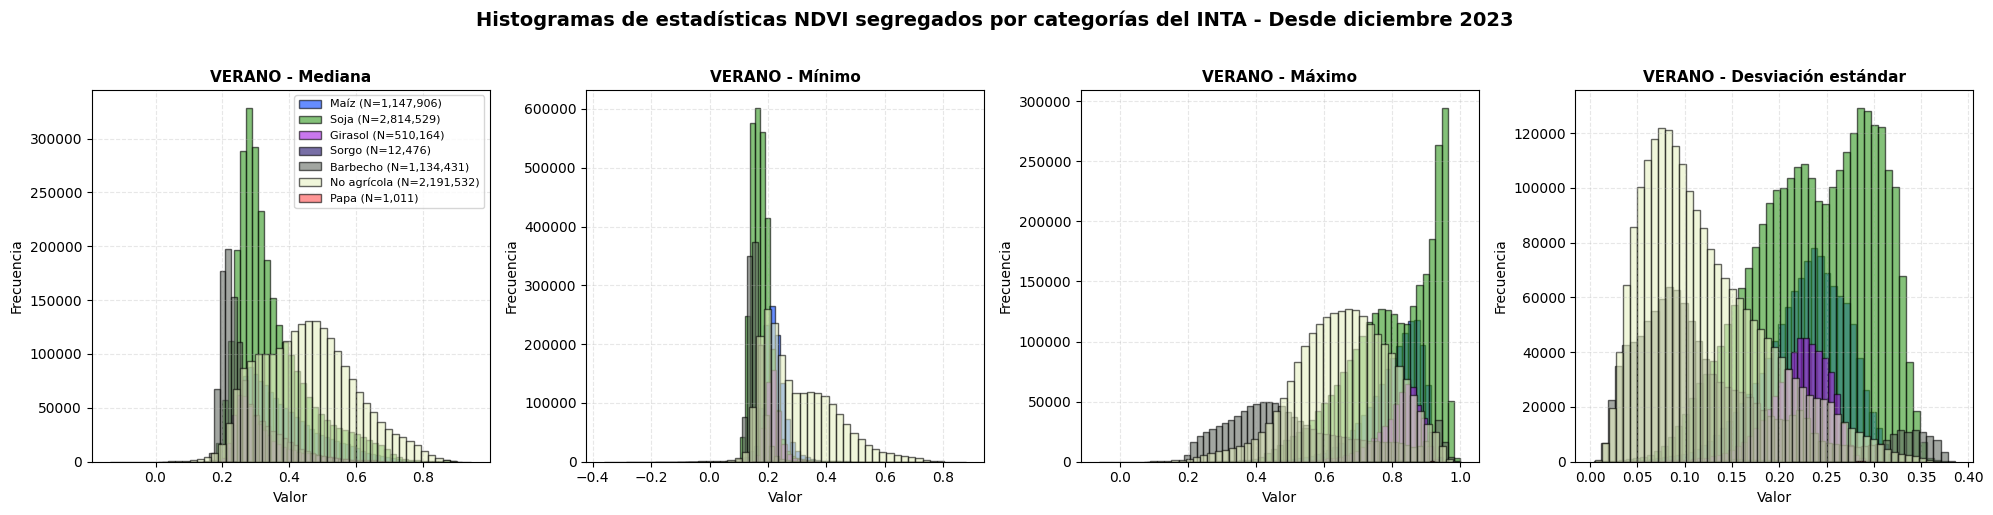


Graficos generados exitosamente usando raster 11_NDVI_inta_verano.tif


In [26]:
# Histogramas segregados por categorías del INTA - Raster 11 (solo verano, desde diciembre 2023)

# Path al nuevo raster
raster_path_11 = os.path.join("..", "data", "proc", "11_NDVI_inta_verano.tif")

# Nombres de las bandas estadísticas (bandas 2-5 en el nuevo raster)
nombres_bandas_11 = {
    2: "Mediana",
    3: "Mínimo",
    4: "Máximo",
    5: "Desviación estándar"
}

# Valores a excluir
valores_excluir = [255, 0, 25, 31]

# Leer el raster
print("Leyendo raster 11_NDVI_inta_verano.tif...")
with rasterio.open(raster_path_11) as src:
    # Leer banda 1 (inta verano)
    banda_verano = src.read(1)
    
    # Leer bandas 2, 3, 4, 5 (estadísticas)
    bandas_estadisticas = {}
    for i in range(2, 6):
        banda = src.read(i)
        # Manejar nodata
        if src.nodata is not None:
            banda = banda.astype(np.float32)
            banda[banda == src.nodata] = np.nan
        else:
            banda = banda.astype(np.float32)
        bandas_estadisticas[i] = banda
    
    print(f"Dimensiones: {src.height} x {src.width}")

# Identificar categorías presentes en VERANO
categorias_presentes_ver = {}
for cat_val in vals_ver:
    if cat_val not in valores_excluir:
        mask = (banda_verano == cat_val)
        n_pixeles = np.sum(mask)
        if n_pixeles > 0:
            idx = vals_ver.index(cat_val)
            categorias_presentes_ver[cat_val] = {
                'label': labels_ver[idx],
                'color': hex_colors_ver[idx],
                'n_pixeles': n_pixeles
            }

print(f"\nCategorías presentes en VERANO: {len(categorias_presentes_ver)}")
for cat_val, info in sorted(categorias_presentes_ver.items()):
    print(f"  {info['label']} (valor={cat_val}, píxeles={info['n_pixeles']:,})")

# Crear visualización 1 fila x 4 columnas (solo verano)
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Crear histogramas para VERANO
for col_idx, (banda_num, nombre) in enumerate(nombres_bandas_11.items()):
    ax = axes[col_idx]
    datos_estadistica = bandas_estadisticas[banda_num]
    
    # Crear histograma para cada categoría de verano
    for cat_val in sorted(categorias_presentes_ver.keys()):
        info = categorias_presentes_ver[cat_val]
        mask_categoria = (banda_verano == cat_val)
        mask_valido = ~np.isnan(datos_estadistica)
        mask_final = mask_categoria & mask_valido
        
        if np.sum(mask_final) > 0:
            datos_categoria = datos_estadistica[mask_final]
            label_con_n = f"{info['label']} (N={info['n_pixeles']:,})"
            ax.hist(datos_categoria, bins=50, alpha=0.6, edgecolor='black', 
                   label=label_con_n, color=info['color'])
    
    ax.set_xlabel("Valor", fontsize=10)
    ax.set_ylabel("Frecuencia", fontsize=10)
    ax.set_title(f"VERANO - {nombre}", fontsize=11, fontweight='bold')
    ax.grid(True, linestyle='--', alpha=0.3)
    if col_idx == 0:
        ax.legend(fontsize=8, loc='best')

plt.suptitle("Histogramas de estadísticas NDVI segregados por categorías del INTA - Desde diciembre 2023", 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f"\nGraficos generados exitosamente usando raster 11_NDVI_inta_verano.tif")
